In [13]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ValueError: Mountpoint must not already contain files

In [14]:
import os
import shutil

mount_point = '/content/drive'
if os.path.exists(mount_point) and os.listdir(mount_point):
    print(f"Clearing non-empty mount point: {mount_point}")
    # Iterate and remove contents
    for item in os.listdir(mount_point):
        item_path = os.path.join(mount_point, item)
        if os.path.isfile(item_path):
            os.remove(item_path)
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)
    print("Mount point cleared. You can now try mounting Google Drive again.")
else:
    print(f"Mount point {mount_point} is already empty or does not exist. Proceeding with drive.mount.")


Clearing non-empty mount point: /content/drive
Mount point cleared. You can now try mounting Google Drive again.


In [15]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [16]:
# Cell 2 — set working dir to your Drive project folder
import os
DRIVE_DIR = "/content/drive/MyDrive/Colab Notebooks/LmFromScratch"
os.makedirs(DRIVE_DIR, exist_ok=True)   # create if missing
%cd "$DRIVE_DIR"
!ls -la


/content/drive/MyDrive/Colab Notebooks/LmFromScratch
total 106954
-rw------- 1 root root 35635899 Nov 13 19:23 best_model.pth
-rw------- 1 root root      167 Nov 13 13:22 diagnostics.json
drwx------ 2 root root     4096 Nov 13 20:59 experiments
-rw------- 1 root root     1447 Nov 13 19:35 losses.pth
-rw------- 1 root root     1364 Nov 14 11:20 model.py
-rw------- 1 root root    35291 Nov 14 14:57 overfitting.ipynb
-rw------- 1 root root   711343 Nov 10 17:06 Pride_and_Prejudice-Jane_Austen.txt
drwx------ 2 root root     4096 Nov 13 13:33 __pycache__
-rw------- 1 root root    22028 Nov 14 15:37 RegularizedFit.ipynb
-rw------- 1 root root  7268877 Nov 13 13:22 test.pt
-rw------- 1 root root 58235797 Nov 13 13:22 train.pt
-rw------- 1 root root     8577 Nov 14 11:20 train.py
-rw------- 1 root root     6307 Nov 14 11:48 train_underfit.py
-rw------- 1 root root     5395 Nov 14 15:28 train_underfit_strict.py
-rw------- 1 root root    59460 Nov 14 15:38 Untitled0.ipynb
-rw------- 1 root root 

In [18]:
%%bash
cat > model.py <<'PY'
# model.py
import torch
import torch.nn as nn

class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=2,
                 dropout=0.3, embed_dropout=0.1, padding_idx=0):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=padding_idx)
        self.embed_dropout = nn.Dropout(embed_dropout) if embed_dropout and embed_dropout > 0 else nn.Identity()
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.out_dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x, hidden=None):
        # x: (B, T)
        emb = self.embed(x)                 # (B, T, E)
        emb = self.embed_dropout(emb)
        if hidden is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
            hidden = (h0, c0)
        out, hidden = self.lstm(emb, hidden) # out: (B, T, H)
        out = self.out_dropout(out)
        logits = self.fc(out)               # (B, T, V)
        return logits, hidden

PY

In [19]:
%%bash
cat > train.py <<'PY'
# train.py
import os
import json
import math
import time
import argparse
import logging
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from model import LSTMLanguageModel

# -----------------------
# Argument parsing
# -----------------------
parser = argparse.ArgumentParser()
parser.add_argument("--drive_dir", type=str, default=".", help="Base folder (Colab Drive or local).")
parser.add_argument("--experiment", type=str, default="bestfit", help="Experiment name (used for saving).")
parser.add_argument("--epochs", type=int, default=15)
parser.add_argument("--batch_size", type=int, default=32)
parser.add_argument("--lr", type=float, default=None)
parser.add_argument("--hidden_size", type=int, default=None)
parser.add_argument("--embed_size", type=int, default=None)
parser.add_argument("--num_layers", type=int, default=None)
parser.add_argument("--dropout", type=float, default=None)
parser.add_argument("--embed_dropout", type=float, default=None)
parser.add_argument("--weight_decay", type=float, default=None)
parser.add_argument("--patience", type=int, default=2)
parser.add_argument("--seed", type=int, default=42)
parser.add_argument("--smoke", action="store_true", help="Run 1-epoch smoke test and exit.")
args = parser.parse_args()

# -----------------------
# Experiment presets (Preset A = best-fit)
# -----------------------
# Default best-fit hyperparameters:
preset = {
    "embed_size": 256,
    "hidden_size": 256,
    "num_layers": 2,
    "dropout": 0.45,
    "embed_dropout": 0.10,
    "lr": 5e-4,
    "weight_decay": 1e-5,
    "batch_size": 32,
    "epochs": 15,
    "clip": 1.0,
    "patience": args.patience
}

# Apply CLI overrides (if provided)
if args.embed_size is not None: preset["embed_size"] = args.embed_size
if args.hidden_size is not None: preset["hidden_size"] = args.hidden_size
if args.num_layers is not None: preset["num_layers"] = args.num_layers
if args.dropout is not None: preset["dropout"] = args.dropout
if args.embed_dropout is not None: preset["embed_dropout"] = args.embed_dropout
if args.lr is not None: preset["lr"] = args.lr
if args.weight_decay is not None: preset["weight_decay"] = args.weight_decay
if args.batch_size is not None: preset["batch_size"] = args.batch_size
if args.epochs is not None: preset["epochs"] = args.epochs

# Smoke test shortcut
if args.smoke:
    preset["epochs"] = 1
    preset["batch_size"] = min(16, preset["batch_size"])

# -----------------------
# Repro & device
# -----------------------
random.seed(args.seed)
torch.manual_seed(args.seed)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------
# Create experiment folder + logger
# -----------------------
timestamp = time.strftime("%Y%m%d-%H%M%S")
exp_name = f"{args.experiment}_{timestamp}"
exp_dir = os.path.join(args.drive_dir, "experiments", exp_name)
os.makedirs(exp_dir, exist_ok=True)

# Logger that logs to console and file
logger = logging.getLogger("train_logger")
logger.setLevel(logging.INFO)
fmt = logging.Formatter("%(asctime)s %(message)s", "%H:%M:%S")
# console
ch = logging.StreamHandler()
ch.setFormatter(fmt)
logger.addHandler(ch)
# file
fh = logging.FileHandler(os.path.join(exp_dir, f"train_{args.experiment}.log"))
fh.setFormatter(fmt)
logger.addHandler(fh)

logger.info(f"Experiment dir: {exp_dir}")
logger.info(f"Preset hyperparameters: {preset}")

# -----------------------
# Data loader
# -----------------------
def load_data(drive_dir):
    # Expect data_prep.py already run and saved train.pt/val.pt/test.pt and vocab.json
    train = torch.load(os.path.join(drive_dir, "train.pt"))
    val   = torch.load(os.path.join(drive_dir, "val.pt"))
    test  = torch.load(os.path.join(drive_dir, "test.pt"))
    with open(os.path.join(drive_dir, "vocab.json"), "r", encoding="utf-8") as f:
        vocab = json.load(f)
    vocab_size = len(vocab["word2id"])
    train_loader = DataLoader(TensorDataset(train["x"], train["y"]), batch_size=preset["batch_size"],
                              shuffle=True, drop_last=True)
    val_loader = DataLoader(TensorDataset(val["x"], val["y"]), batch_size=preset["batch_size"],
                            shuffle=False, drop_last=False)
    test_loader = DataLoader(TensorDataset(test["x"], test["y"]), batch_size=preset["batch_size"],
                             shuffle=False, drop_last=False)
    return train_loader, val_loader, test_loader, vocab_size

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total, count = 0.0, 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits, _ = model(x)
        loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
        total += loss.item() * x.size(0)
        count += x.size(0)
    avg = total / count
    return avg, math.exp(avg)

# -----------------------
# Training loop
# -----------------------
def train(drive_dir, exp_dir):
    train_loader, val_loader, test_loader, vocab_size = load_data(drive_dir)
    model = LSTMLanguageModel(vocab_size=vocab_size,
                              embed_size=preset["embed_size"],
                              hidden_size=preset["hidden_size"],
                              num_layers=preset["num_layers"],
                              dropout=preset["dropout"],
                              embed_dropout=preset["embed_dropout"]).to(DEVICE)

    criterion = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = optim.Adam(model.parameters(), lr=preset["lr"], weight_decay=preset["weight_decay"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1)

    best_val = float("inf")
    stalled = 0
    patience = preset["patience"]
    train_losses, val_losses = [], []

    for epoch in range(1, preset["epochs"] + 1):
        model.train()
        total_train = 0.0
        for batch_idx, (x, y) in enumerate(train_loader): # Added enumerate to get batch_idx
            if batch_idx % 100 == 0: # Print every 100 batches
                logger.info(f"Epoch {epoch}/{preset['epochs']} - Processing batch {batch_idx}/{len(train_loader)}")
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            logits, _ = model(x)
            loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_train += loss.item() * x.size(0)
        avg_train = total_train / len(train_loader.dataset)
        val_loss, val_ppl = evaluate(model, val_loader, criterion)

        train_losses.append(avg_train); val_losses.append(val_loss)
        logger.info(f"Epoch {epoch}/{preset['epochs']} | Train loss: {avg_train:.4f} | Val loss: {val_loss:.4f} | Val ppl: {val_ppl:.2f}")

        # scheduler step (use val_loss)
        scheduler.step(val_loss)
        logger.info(f"Scheduler LR: {optimizer.param_groups[0]['lr']}")

        # early stopping + checkpoint
        if val_loss < best_val:
            best_val = val_loss
            stalled = 0
            best_path = os.path.join(exp_dir, f"best_model_{args.experiment}.pth")
            torch.save(model.state_dict(), best_path)
            logger.info(f" Saved best model to {best_path}")
        else:
            stalled += 1
            if stalled > patience:
                logger.info(f"No improvement for {patience} epochs -> early stopping")
                break

    # load best and evaluate test
    best_path = os.path.join(exp_dir, f"best_model_{args.experiment}.pth")
    if os.path.exists(best_path):
        model.load_state_dict(torch.load(best_path))
        test_loss, test_ppl = evaluate(model, test_loader, criterion)
        logger.info(f"Test loss: {test_loss:.4f} | Test perplexity: {test_ppl:.2f}")
    else:
        logger.warning("No best model saved; skipping final test eval.")
        test_loss, test_ppl = None, None

    # Save losses & metadata
    torch.save({"train_losses": train_losses, "val_losses": val_losses}, os.path.join(exp_dir, f"losses_{args.experiment}.pth"))
    meta = {
        "preset": preset,
        "seed": args.seed,
        "final_test_loss": test_loss,
        "final_test_ppl": test_ppl
    }
    with open(os.path.join(exp_dir, f"meta_{args.experiment}.json"), "w", encoding="utf-8") as f:
        json.dump(meta, f, indent=2)

    logger.info(f"Experiment artifacts saved to {exp_dir}")

if __name__ == "__main__":
    train(args.drive_dir, exp_dir)

PY

In [ ]:
!python train.py --drive_dir "." --experiment bestfit --epochs 1 --batch_size 32

In [ ]:
!python train.py --drive_dir "." --experiment bestfit_full --epochs 15 --batch_size 32


Best validation loss = 4.4771 at Epoch 2.

Val loss sequence: [4.5498, 4.4771, 4.5466, 4.6527, 4.7427] → best at epoch 2, then no lasting improvement.

Scheduler reduced LR once (0.0005 → 0.00025) at epoch 4.

Early stopping triggered after 2 epochs without improvement (stopped after epoch 5).

Final test loss 5.3420, test ppl ≈ 209.

Conclusion: regularization + smaller model worked — model stopped improving early (good), but there's still headroom to push val/test down further with modest tuning.

In [20]:
!python train.py --drive_dir "." --experiment bestfit_lr_slow --epochs 20 \
  --batch_size 32 --lr 2e-4 --patience 3 --weight_decay 3e-5 --dropout 0.5 --embed_dropout 0.15 --hidden_size 224


15:40:04 Experiment dir: ./experiments/bestfit_lr_slow_20251114-154004
15:40:04 Preset hyperparameters: {'embed_size': 256, 'hidden_size': 224, 'num_layers': 2, 'dropout': 0.5, 'embed_dropout': 0.15, 'lr': 0.0002, 'weight_decay': 3e-05, 'batch_size': 32, 'epochs': 20, 'clip': 1.0, 'patience': 3}
15:40:15 Epoch 1/20 - Processing batch 0/3791
15:40:16 Epoch 1/20 - Processing batch 100/3791
15:40:17 Epoch 1/20 - Processing batch 200/3791
15:40:18 Epoch 1/20 - Processing batch 300/3791
15:40:19 Epoch 1/20 - Processing batch 400/3791
15:40:20 Epoch 1/20 - Processing batch 500/3791
15:40:21 Epoch 1/20 - Processing batch 600/3791
15:40:21 Epoch 1/20 - Processing batch 700/3791
15:40:23 Epoch 1/20 - Processing batch 800/3791
15:40:24 Epoch 1/20 - Processing batch 900/3791
15:40:24 Epoch 1/20 - Processing batch 1000/3791
15:40:25 Epoch 1/20 - Processing batch 1100/3791
15:40:26 Epoch 1/20 - Processing batch 1200/3791
15:40:27 Epoch 1/20 - Processing batch 1300/3791
15:40:28 Epoch 1/20 - Process

We ran the “slow LR” experiment and it behaved exactly like a well-behaved small brain should: it crept down the loss, the scheduler chipped in when progress stalled, and early stopping stopped it from wasting cycles.

* Preset used: embed=256, hidden=224, layers=2, dropout=0.5, embed_dropout=0.15,


* lr=2e-4, wd=3e-5, batch=32, epochs=20, patience=3.

* Training behaviour: train loss steadily fell from ~5.51 → ~3.79 by epoch 9.

* Validation: improved early (5.0→4.45), then stalled; best val ~4.46 at epoch 4.

* Scheduler: ReduceLROnPlateau halved the LR twice (2e-4 → 1e-4 at epoch 7; 1e-4 → 5e-5 at epoch 9). You see those lines: “Scheduler LR: 0.0002” then later “Scheduler LR: 0.0001” then “Scheduler LR: 5e-05”.

* Early stopping: triggered when no improvement for patience=3 epochs -> stopped at epoch 9.

* Final test: Test loss 5.2545 | Test ppl 191.43.

The model is learning and generalizing better than earlier runs (val ppl ~86 is better than the worst runs), scheduler + early stopping did what they should: slow the LR when val plateaued, then stop after no improvement.

# Early stop at ~epoch 9 indicates the model’s generalization peaked around epoch 4 and small continued improvements on train weren’t improving val. Scheduler reductions were appropriate but maybe a bit aggressive (factor=0.5).

In [21]:
!nvidia-smi


Fri Nov 14 15:47:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [25]:
%%writefile inspect_data.py
# inspect_data.py
import json, torch, collections, re
from pathlib import Path
p = Path(".")
# 1) sizes of tensors
for name in ("train.pt","val.pt","test.pt"):
    if (p/name).exists():
        t = torch.load(p/name)
        print(name, {k: getattr(v,'shape',None) for k,v in t.items()})
    else:
        print("Missing", name)

# 2) load vocab (word2id) and invert
vocab = json.loads((p/"vocab.json").read_text(encoding="utf8"))
w2i = vocab.get("word2id", vocab.get("token2id", {}))
i2w = {int(i):w for w,i in w2i.items()} if all(isinstance(k,str) for k in w2i.keys()) else {v:k for k,v in w2i.items()}

# 3) sample decoded sequence from train.pt (first batch)
train = torch.load("train.pt")
x = train["x"][:1]  # first example (seq_len)
print("\nSample encoded x shape:", x.shape)
seq = x[0].tolist()
decoded = " ".join(i2w.get(int(tok), "<UNK>") for tok in seq[:60])
print("\nDecoded sample (first 60 tokens):\n", decoded)

# 4) top 50 words from raw text (safe)
if (p/"Pride_and_Prejudice-Jane_Austen.txt").exists():
    txt = (p/"Pride_and_Prejudice-Jane_Austen.txt").read_text(encoding="utf8").lower()
    tokens = re.findall(r"[a-z']+", txt)
    ctr = collections.Counter(tokens)
    print("\nTop 50 words (raw counts):")
    for w,c in ctr.most_common(50):
        print(f"{w:>12} {c}")
else:
    print("Raw text not found for frequency counts")


Writing inspect_data.py


In [26]:
!python inspect_data.py


train.pt {'x': torch.Size([121321, 30]), 'y': torch.Size([121321, 30])}
val.pt {'x': torch.Size([15138, 30]), 'y': torch.Size([15138, 30])}
test.pt {'x': torch.Size([15140, 30]), 'y': torch.Size([15140, 30])}

Sample encoded x shape: torch.Size([1, 30])

Decoded sample (first 60 tokens):
 the project gutenberg ebook , pride and prejudice , by jane austen , edited by r . w . ( robert william ) chapman this ebook is for the use

Top 50 words (raw counts):
         the 4520
          to 4243
          of 3750
         and 3662
         her 2224
           i 2075
           a 2003
          in 1941
         was 1849
         she 1709
        that 1606
          it 1549
         not 1450
         you 1428
          he 1340
         his 1271
          be 1256
          as 1199
         had 1174
        with 1100
         for 1091
         but 1009
          is 883
        have 853
          at 796
          mr 781
         him 765
          on 732
          my 722
          by 661
         a

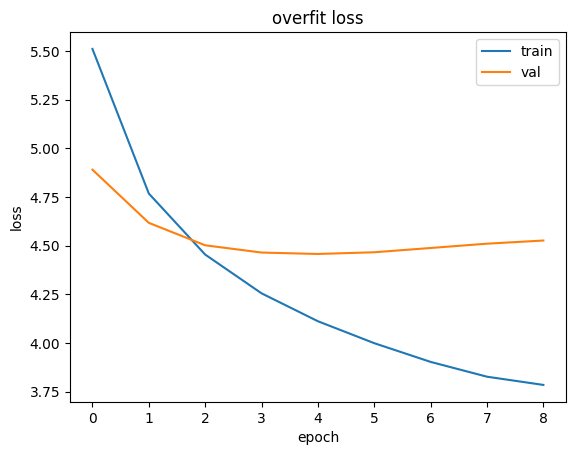

In [27]:
import torch, matplotlib.pyplot as plt, os
d = torch.load(os.path.join(DRIVE_DIR, "experiments/bestfit_lr_slow_20251114-154004/losses_bestfit_lr_slow.pth"))
plt.plot(d["train_losses"], label="train")
plt.plot(d["val_losses"], label="val")
plt.title("overfit loss"); plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.show()